In [1]:
import numpy as np

import os
import matplotlib.pyplot as plt
import cv2
import glob

#Pull files from Kaggle

os.environ['KAGGLE_USERNAME'] = "downlz"
os.environ['KAGGLE_KEY'] = "1238930235c80477af9ebddd89e99b9e"
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

weed-detection-in-soybean-crops.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
from zipfile import ZipFile

zf = ZipFile('weed-detection-in-soybean-crops.zip', 'r')
zf.extractall()
zf.close()

In [0]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (19.0, 17.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
!pwd  #Check current path to set data directory

/content


In [5]:
data_dir = r'/content/dataset/dataset/'
classes = ['broadleaf', 'grass', 'soil', 'soybean'] 

num_file = 1100 
all_files = [] 
num_data =num_file*len(classes)
Y = np.zeros(num_data)


for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file]
    Y[i*num_file:(i+1)*num_file] = i # label all classes with int [0.. len(classes)]

    
# Image dimension
im_width = 200
im_height = 200 
im_channel = 3
dim = im_width * im_height * im_channel

X = np.ndarray(shape=(num_data, im_width, im_height, im_channel), dtype=np.float64)

for idx, file in enumerate(all_files):
    X[idx] = cv2.resize(cv2.imread(file), (im_width, im_height))

X_train = np.empty(shape=(4000,im_width, im_height, im_channel), dtype=np.float64)
X_val = np.empty(shape=(200,im_width, im_height, im_channel), dtype=np.float64)
X_test = np.empty(shape=(200,im_width, im_height, im_channel), dtype=np.float64)

y_train = np.empty(4000)
y_val = np.empty(200)
y_test = np.empty(200) 

for i, cls in enumerate(classes): 
    X_test[50*i:50*(i+1)] = X[np.where(Y == i)[0][:50]]
    X_val[50*i:50*(i+1)] = X[np.where(Y == i)[0][50:100]]
    X_train[1000*i:1000*(i+1)] = X[np.where(Y == i)[0][100:]]
    
    y_test[50*i:50*(i+1)] = i
    y_val[50*i:50*(i+1)] = i
    y_train[1000*i:1000*(i+1)] = i
    
del Y 
del X

# Extract features 
#Shuffle training index
train_idxs = np.random.permutation(X_train.shape[0])
y_train  = y_train[train_idxs].astype(int)
X_train = X_train[train_idxs]

X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

X_tiny = X_train[100:110].astype('float64')
y_tiny = y_train[100:110].astype(int)
num_dev = 500

X_dev = X_train[0:num_dev].astype('float64')
y_dev = y_train[0:num_dev].astype(int)
print("X_train shape", X_train.shape, "| y_train shape:", y_train.shape)
print("X_test shape", X_test.shape, "| y_test shape:", y_test.shape)
print("X_val shape", X_val.shape, "| y_val shape:", y_val.shape)
print("X_dev shape", X_dev.shape, "| y_dev shape:", y_dev.shape)
print("X_tiny shape", X_tiny.shape, "| y_tiny shape:", y_tiny.shape)

#Subtract out the mean image 
#first: compute the mean image
# mean_image = np.mean(X_train, axis=0) #axis=0. stack horizontally
mean_image = 128
#Second subtract the mean image from train and test data 
X_train -= mean_image
X_val -= mean_image 
X_test -= mean_image
X_dev -= mean_image
X_tiny -= mean_image

print('=====STACK BIAS term=====')
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("X_val shape", X_val.shape)
print("X_dev shape", X_dev.shape)
print("X_tiny shape", X_tiny.shape)

X_train shape (4000, 120000) | y_train shape: (4000,)
X_test shape (200, 120000) | y_test shape: (200,)
X_val shape (200, 120000) | y_val shape: (200,)
X_dev shape (500, 120000) | y_dev shape: (500,)
X_tiny shape (10, 120000) | y_tiny shape: (10,)
=====STACK BIAS term=====
X_train shape (4000, 120000)
X_test shape (200, 120000)
X_val shape (200, 120000)
X_dev shape (500, 120000)
X_tiny shape (10, 120000)


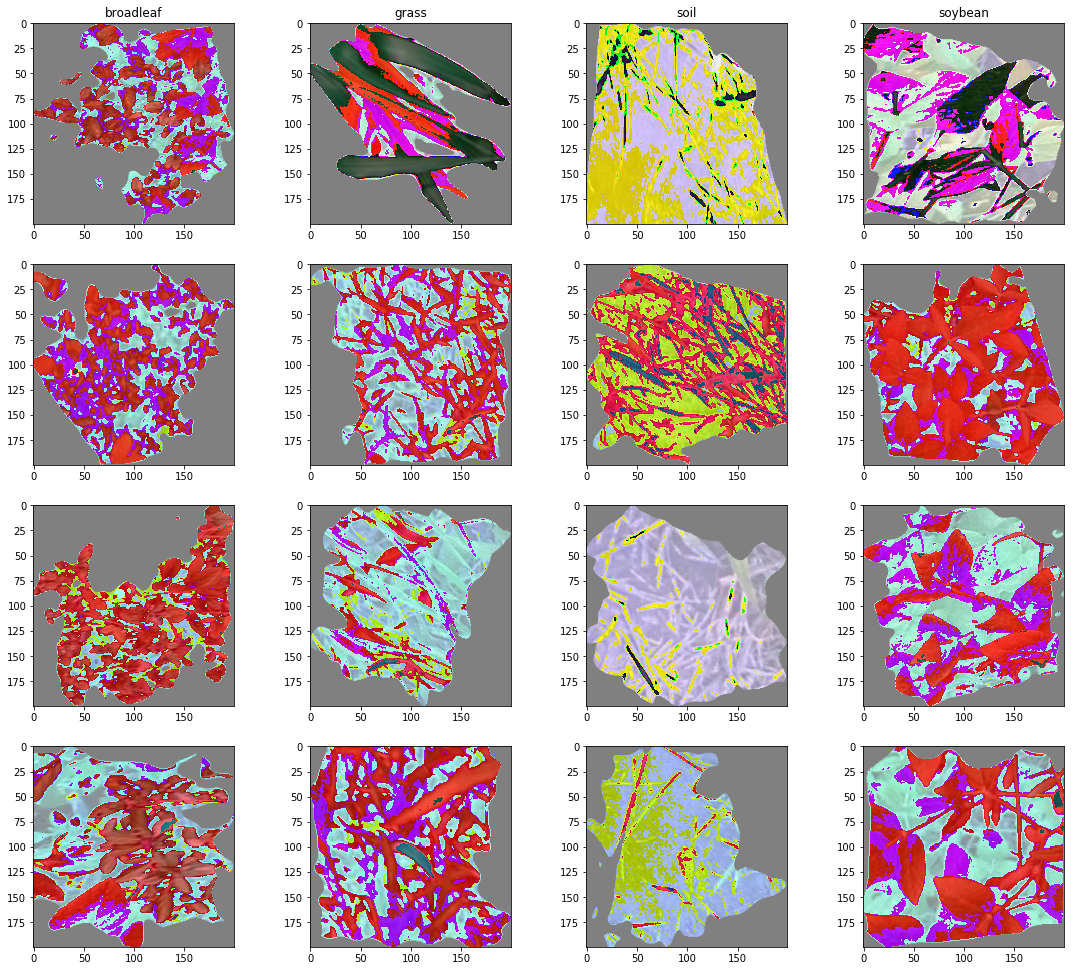

In [6]:
classes = ['broadleaf', 'grass', 'soil', 'soybean']
n_class = len(classes)
samples_per_class = 4


for y, cls in enumerate(classes):
    idxes = np.flatnonzero(y == y_train)
    idxes = np.random.choice(idxes, samples_per_class, replace = False)
    for i, idx in enumerate(idxes):
        plt_idx = i * n_class + y + 1
        plt.subplot(samples_per_class,n_class, plt_idx)
        plt.imshow(X_train[idx].reshape(im_width, im_height, im_channel).astype('uint8'))
        if(i==0): plt.title(cls)

plt.show()

In [0]:
class neuralNetwork():
    def __init__(self, input_size, hidden_size, output_size, std):
        
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y = None, reg=0.0):
      
        #relu activation function 
        relu = lambda x:np.maximum(0,x)

        #unpack
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        #Forward prop
        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2

        #if target is not given then jump out 
        if(y is None): 
            return scores

        #compute the loss 
        ##Normalization trick to prevent overflow when compute exp 
        scores -= scores.max()#stack vertically

        scores = np.exp(scores)
        scores_sumexp = np.sum(scores, axis=1)#stack vertically

        ##Nomalize all score 
        softmax = scores / scores_sumexp.reshape(N,1)  #Shape: (N, C)
        #total loss of all training. -log of all correct score
        loss =  (-1.0) * np.sum(np.log(softmax[range(N),y]))

        ##Normalize the loss and add regularization strength 
        loss /= N 
        loss += reg * np.sum(W1 * W1) 
        loss += reg * np.sum(W2 * W2) 

        #Backward pass on the net 
        grads = {}

        correct_class_scores = scores[range(N), y]
        softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_class_scores)/scores_sumexp
        softmax /= N

        grads['W2'] = layer1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0) #stack horizontally
        grads['W2'] += reg * 2 * W2

        hidden = softmax.dot(W2.T)

        hidden[layer1 == 0] = 0 

        grads['W1'] = X.T.dot(hidden) 
        grads['b1'] = np.sum(hidden, axis=0) #stack horizontally 
        grads['W1'] += reg * 2 * W1

        return loss, grads

    def train(self, X, y, X_val, y_val, 
              learning_rate =1e-3, learning_rate_decay=0.95, 
              reg=5e-6, epochs=100, 
              batch_size=200):
        
        N, D = X.shape
        N_val = X_val.shape[0]
        iteration_per_epoch = max(N/batch_size, 1)
        
        loss_hist = []
        train_acc_hist = []
        val_acc_hist = []
        
        for it in range(epochs):
            sampling = np.random.choice(np.arange(N), batch_size, replace=False) 
            X_batch = X[sampling]
            y_batch = y[sampling]
            
            #compute loss and gradients
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_hist.append(loss) 
            
            #Update rule 
            self.params['W1'] += (-1.0) * learning_rate * grads['W1']
            self.params['b1'] += (-1.0) * learning_rate * grads['b1']
            self.params['W2'] += (-1.0) * learning_rate * grads['W2']
            self.params['b2'] += (-1.0) * learning_rate * grads['b2']
            
            if it % 10 == 0:
              print('Iteration : %d / %d | Loss: %f' % (it, epochs, loss))
            
            if (it % iteration_per_epoch == 0):
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay
        return {
            'loss_hist':loss_hist,
            'train_acc_hist':train_acc_hist,
            'val_acc_hist':val_acc_hist
        }

    def predict(self, X):
        y_pred = None
        relu = lambda x:np.maximum(0,x)
        
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        #Forward propagation though the network 
        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2 #shape: (N x C)
        y_pred = np.argmax(scores, axis=1)

        return y_pred

In [0]:
input_size = im_width * im_height * im_channel
hidden_size = 200
output_size = n_class 
std = 1e-3 

net = neuralNetwork(input_size, hidden_size,output_size,std )

In [9]:
stats = net.train(X_dev, y_dev, X_val, y_val, 
              learning_rate =1e-5, learning_rate_decay=0.95, 
              reg=0.0, epochs=600, 
              batch_size=100)

Iteration : 0 / 250 | Loss: 1.405220
Iteration : 10 / 250 | Loss: 1.366658
Iteration : 20 / 250 | Loss: 1.246485
Iteration : 30 / 250 | Loss: 1.265832
Iteration : 40 / 250 | Loss: 1.188725
Iteration : 50 / 250 | Loss: 1.159769
Iteration : 60 / 250 | Loss: 1.130176
Iteration : 70 / 250 | Loss: 1.109439
Iteration : 80 / 250 | Loss: 1.095439
Iteration : 90 / 250 | Loss: 1.081544
Iteration : 100 / 250 | Loss: 0.986672
Iteration : 110 / 250 | Loss: 1.030050
Iteration : 120 / 250 | Loss: 1.009863
Iteration : 130 / 250 | Loss: 0.984409
Iteration : 140 / 250 | Loss: 0.947369
Iteration : 150 / 250 | Loss: 0.993008
Iteration : 160 / 250 | Loss: 0.945883
Iteration : 170 / 250 | Loss: 0.932198
Iteration : 180 / 250 | Loss: 0.960574
Iteration : 190 / 250 | Loss: 0.884281
Iteration : 200 / 250 | Loss: 0.888152
Iteration : 210 / 250 | Loss: 0.924516
Iteration : 220 / 250 | Loss: 0.923577
Iteration : 230 / 250 | Loss: 0.931630
Iteration : 240 / 250 | Loss: 0.868198


In [10]:
print((net.predict(X_test) == y_test).mean())

0.655


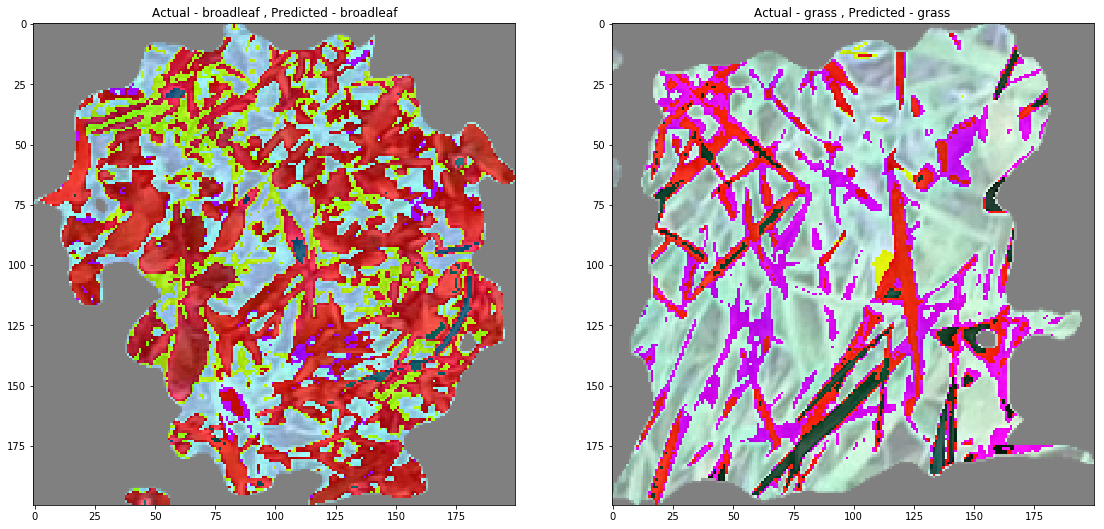

In [11]:
# Picking images randomly and checking prediction

idxes = np.flatnonzero(y_train == 0)
idxes = np.random.choice(idxes, 1, replace=False)
prediction = net.predict(X_train[idxes])

plt.subplot(1, 2, 1)
plt.title('{} , {}'.format('Actual - ' + classes[0], 'Predicted - ' + classes[prediction[0]]))
plt.imshow(X_train[idxes].reshape(im_width, im_height, im_channel).astype('uint8'))

idxes = np.flatnonzero(y_train == 1)
idxes = np.random.choice(idxes, 1, replace=False)
prediction = net.predict(X_train[idxes])

plt.subplot(1, 2, 2)
plt.title('{} , {}'.format('Actual - ' + classes[1], 'Predicted - ' + classes[prediction[0]]))
plt.imshow(X_train[idxes].reshape(im_width, im_height, im_channel).astype('uint8'))